# Advanced Machine Learning - Practicum 6 - Convolutional Neural Network

**Topics covered**: Convolutional Neural Network

**Deliverables**:
- Complete the tasks as detailed in this document.  <br>
- The keras model file `mymodel.h5` (see Task 2 for detail). <br>
This practice uses [Keras](https://keras.io/api/) with Tensorflow.

**Objectives**:
After completing the tasks, you'll know how to:
- implement a simplified 7-layer LeNet CNN, and <br>
- apply it for object recognition. <br>
- design and implement a convnet model on a given data set. <br>

---
Import needed packages

In [1]:
import numpy as np
import tensorflow as tf    # one-hot encode
from PIL import Image
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from keras import optimizers
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split

In [2]:
import keras as kr
print(kr.__version__)
# 2.4.3

2.4.3


## 1. Task 1 - Implement a convnet

### 1.1 Load image and Get train, test data set
The facial images are frm **olivettifaces** we used before. <br>
There are ten different images of each of 40 distinct subjects. The image is quantized to 256 grey levels and stored as unsigned 8-bit integers. Size of each image is 57 by 47 with 1 channel.<br>
In order to adapt to convnets, the data and target need to be reshaped. <br>
Run code in cell below to get `train_data`, `train_target`, `test_data`, `test_target`

In [3]:
# Load and normalize face image data
def load_images(filename):
    
    # open files, use Image.open()
    img = Image.open(filename)
    
    # Normalize pixle values, let it with range [0,1]
    img_ndarray = np.asarray(img, dtype='float32')/255
    
    # Split the entire image into 400 samples
    faces = np.empty((400,2679),dtype='float32')
    for row in range(20):
        for column in range(20):
            faces[row*20+column] = np.ndarray.flatten(img_ndarray[row*57:(row+1)*57,column*47:(column+1)*47])
    print(f'faces:{faces}{faces.shape}\n')        
    # Create target array    
    target = np.empty(400)
    for i in range(40):
        target[i*10:i*10+10]=i

    target=target.astype(np.int)
    
    #train, validation
    train_data=np.empty((360,2679),dtype='float32')
    train_target=np.empty(360)
    test_data=np.empty((40,2679),dtype='float32')
    test_target=np.empty(40)

    for i in range(40):
        train_data[i*9:i*9+9]=faces[i*10:i*10+9]
        train_target[i*9:i*9+9]=target[i*10:i*10+9]
        test_data[i]=faces[i*10+9]
        test_target[i]=target[i*10+9]
        
    # reshape
    train_data = train_data.reshape((360,57,47,1))
    test_data = test_data.reshape((40,57,47,1))
    
    # one-hot encode for target
    train_target = tf.keras.utils.to_categorical(train_target)
    test_target = tf.keras.utils.to_categorical(test_target)    
        
    return train_data, train_target, test_data, test_target

train_data, train_target, test_data, test_target = load_images("olivettifaces.gif")  


faces:[[0.1882353  0.1764706  0.19215687 ... 0.9647059  0.9647059  0.9647059 ]
 [0.23529412 0.24313726 0.1882353  ... 0.9647059  0.9647059  0.9647059 ]
 [0.15294118 0.20784314 0.23921569 ... 0.9647059  0.9647059  0.9647059 ]
 ...
 [0.9647059  0.49019608 0.4862745  ... 0.9647059  0.9647059  0.9647059 ]
 [0.9647059  0.46666667 0.47058824 ... 0.9647059  0.9647059  0.9647059 ]
 [0.9647059  0.49019608 0.4862745  ... 0.9647059  0.9647059  0.9647059 ]](400, 2679)



In [4]:
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(360, 57, 47, 1) (360, 40) (40, 57, 47, 1) (40, 40)


### 1.2 Build Convnet model
Implement function `build_CNN()` to build the convnet described as following: <br>
1)	Layer 0 - conv2d_1 (Conv2D), 5 kernels, size of kernel: 5 by 5, input of this layer is a 3D tesnor (57, 47, 1), activation function is tanh <br>
2)	Layer 1 - maxpooling2d_1 (MaxPooling2D), 2 by 2 pooling <br>
3)	Layer 2 - conv2d_2 (Conv2D), 10 kernels, size of kernel: 5 by 5, activation function is tanh <br>
4)	Layer 3 - maxpooling2d_2 (MaxPooling2D), 2 by 2 pooling <br>
5)	Layer 4 - flatten_1 (Flatten) <br>
6)	Layer 5 - dense_1 (Dense), 1000 nodes, activation function is tanh <br>
7)	Layer 6 - dense_2(Dense), 40 nodes, activation function is softmax


In [5]:
def build_CNN():
    
    # Your code goes here
    network = models.Sequential()
    network.add(Conv2D(5, (5, 5), activation='tanh', input_shape=(57, 47, 1)))  # layer 0
    network.add(MaxPooling2D(pool_size=(2, 2)))                                 # layer 1                        
    network.add(Conv2D(10, (5, 5), activation='tanh'))                          # layer 2
    network.add(MaxPooling2D(pool_size=(2, 2)))                                 # layer 3
    network.add(Flatten())                         # layer 4
    network.add(Dense(1000, activation='tanh'))    # layer 5
    network.add(Dense(40, activation='softmax'))   # layer 6
    network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return network

### 1.3 Train the convnet
- Call `build_CNN` get the convnet model
- Compile the modle (`compile()`, use the following hyperparameter setting to compile the model.<br>
    1) `optimizer=rmsprop` <br>
    2) `loss=categorical_crossentropy` <br>
    3) `metrics=[‘accuracy’]`. <br>
- Train the model (`fit()`). <br>
    1) Apply **early stopping** in the learning/fitting process. Click [here](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/) for a introduction of very basic use of early stopping. <br>
    2) Plot the learning curve by using the returned result from `fit()`

In [6]:
# Your code goes here
model = build_CNN()

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

# Train neural network
history = model.fit(train_data,             # Features
                      train_target,         # Target vector
                      epochs=20,            # Number of epochs
                      callbacks=callbacks,  # Early stopping
                      verbose=2,            # Print description after each epoch
                      batch_size=100,       # Number of observations per batch
                      validation_data=(test_data, test_target)) # Data for evaluation

Epoch 1/20
4/4 - 0s - loss: 4.0305 - accuracy: 0.0306 - val_loss: 3.3701 - val_accuracy: 0.2000
Epoch 2/20
4/4 - 0s - loss: 3.1545 - accuracy: 0.3028 - val_loss: 2.9690 - val_accuracy: 0.4250
Epoch 3/20
4/4 - 0s - loss: 2.6315 - accuracy: 0.5833 - val_loss: 2.5656 - val_accuracy: 0.4000
Epoch 4/20
4/4 - 0s - loss: 2.0714 - accuracy: 0.6528 - val_loss: 2.0598 - val_accuracy: 0.5250
Epoch 5/20
4/4 - 0s - loss: 1.5351 - accuracy: 0.7750 - val_loss: 1.7824 - val_accuracy: 0.6250
Epoch 6/20
4/4 - 0s - loss: 1.1656 - accuracy: 0.8278 - val_loss: 1.4395 - val_accuracy: 0.6750
Epoch 7/20
4/4 - 0s - loss: 0.8069 - accuracy: 0.9333 - val_loss: 1.1519 - val_accuracy: 0.7000
Epoch 8/20
4/4 - 0s - loss: 0.5424 - accuracy: 0.9556 - val_loss: 1.0219 - val_accuracy: 0.7500
Epoch 9/20
4/4 - 0s - loss: 0.4166 - accuracy: 0.9611 - val_loss: 1.1553 - val_accuracy: 0.7000
Epoch 10/20
4/4 - 0s - loss: 0.3248 - accuracy: 0.9722 - val_loss: 0.7554 - val_accuracy: 0.8250
Epoch 11/20
4/4 - 0s - loss: 0.2005 - a

### 1.4 Plot learning curve on train loss

In [7]:
#display summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 53, 43, 5)         130       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 21, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 17, 10)        1260      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 8, 10)         0         
_________________________________________________________________
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              881000    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


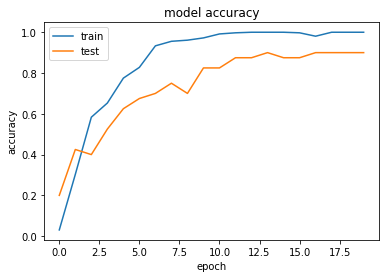

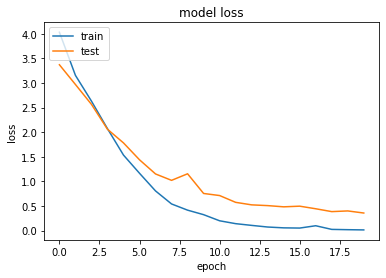

In [8]:
# display the loss curves

# Your code goes here

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.5 Make prediction
Run the code below to evaluate the model and observe the prediction result.

In [9]:
model.evaluate(test_data, test_target)
predictions = model.predict(test_data)

2/2 [==============================] - 0s 3ms/step - loss: 0.3582 - accuracy: 0.9000


`predict` function returns a probability distribution over all 40 subjects. How do we get the identity from the `predctions`, type the statement in the cell below

In [10]:
# predict the label
# Your code goes here

labels = np.array([np.argmax(pred, axis = 0) for pred in predictions]) # get the index of the biggest value in each of pred
correct = np.arange(40) # total 40 from 0 to 40
misclass = [correct[i] for i in range(len(labels)) if labels[i] != correct[i]] # pick out the misscl

# print()
print(f'Labels: \n{labels}\n')
print(f'Misclassified subjects: \n{misclass}')

Labels: 
[ 0  1  2  3  4  5  4  7 39  9 10 11 12 13 14 15 16 17 31 19 20 21 22 23
 24 25 26 27 28 39 30 31 32 33 34 35 36 37 38 39]

Misclassified subjects: 
[6, 8, 18, 29]


**How many subjects are wrongly classified? Give the identity of those subjects?**

Ans: 3 subjects are wrongly classified. They are number 6, , 8, 18 and 29

---

## 2. Task 2 - Build up your own convnet

In this task you're to build your own model and train it on the cats and dogs images. Save and submit your best modle (`model.save()` can be used to save your modle onto the disk).

### 2.1 Load Data
This task focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing. The original dataset could be downloaded from www.kaggle.com/c/dogs-vs-cats/data <br>
We'll use the split dataset which can be downloaded from the moodle course page.

In [11]:
# specify the folder of train, validation and test data set
import os, cv2, re, random
import pandas as pd
# C:/Users/kaino/Documents/digipen lessons/digi_ml/AM-P06-Convolutional Neural Network/
# Change the follwing path if the dataset is not located here
train_dir = "dogvscat/train" 
validation_dir = "dogvscat/validation"
test_dir = "dogvscat/test"

train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [12]:
VALID_FRACTION = 0.2
BATCH_SIZE = 20
EPOCHS = 30

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(train_dir)
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

In [13]:
# Using ImageDataGenerator to read images from directories
# The generator yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)).
# There are 20 samples in each batch (the batch size).

from keras.preprocessing.image import ImageDataGenerator

# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 2.2 Bulid your convnet and Train it

Design and implement your own model for classifying cats and dogs images. Save the trained model into the file `mymodel.h5`. <br>
When calling `fit()`, `train_data, train_target` should be replace with `train_generator`, and use `validation_generator` to initialize parameter `validation_data`.

In [23]:
# Your code goes here
dogcat = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')])

dogcat.summary()

dogcat.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

In [28]:
# training

TRAIN_SIZE = 2000
VALID_FRACTION = 0.2
BATCH_SIZE = 20
EPOCHS = 30

history_dogcat = dogcat.fit(train_generator, validation_data=validation_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

dogcat.save('dogvscat/mymodel.h5')

Epoch 1/30
80/80 [==============================] - 30s 375ms/step - loss: 0.3941 - accuracy: 0.8325 - val_loss: 0.6438 - val_accuracy: 0.7225
Epoch 2/30
80/80 [==============================] - 31s 383ms/step - loss: 0.3646 - accuracy: 0.8288 - val_loss: 0.7156 - val_accuracy: 0.6875
Epoch 3/30
80/80 [==============================] - 30s 379ms/step - loss: 0.3586 - accuracy: 0.8487 - val_loss: 0.5569 - val_accuracy: 0.7675
Epoch 4/30
80/80 [==============================] - 31s 383ms/step - loss: 0.3297 - accuracy: 0.8575 - val_loss: 0.5493 - val_accuracy: 0.7600
Epoch 5/30
80/80 [==============================] - 31s 385ms/step - loss: 0.3169 - accuracy: 0.8675 - val_loss: 0.5237 - val_accuracy: 0.7650
Epoch 6/30
80/80 [==============================] - 31s 385ms/step - loss: 0.2770 - accuracy: 0.8875 - val_loss: 0.6107 - val_accuracy: 0.7700
Epoch 7/30
80/80 [==============================] - 31s 390ms/step - loss: 0.2891 - accuracy: 0.8881 - val_loss: 0.7740 - val_accuracy: 0.7375

In [30]:
# run the code below to load and evaluate your model

model_stu = kr.models.load_model('dogvscat/mymodel.h5') # load the model

# test_generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')
model_stu.evaluate(test_generator) # evaluate the loaded model

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 95ms/step - loss: 0.6567 - accuracy: 0.7420


[0.6567167639732361, 0.7419999837875366]